# Определение возраста покупателей

Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings("ignore")

In [12]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [13]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [14]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [15]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим распределение по возрасту уже по графику, но уже из описания понятно, что до 75% выборки это люди до 41 года, значит чем старше человек, тем ниже количество данных и тем слабее будет на этой группе обучена модель

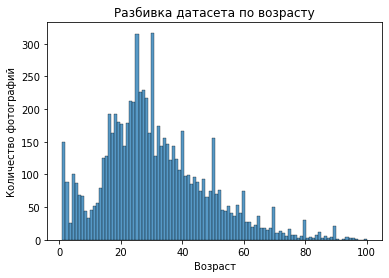

In [16]:
sns.histplot(labels["real_age"], bins=100)
plt.title('Разбивка датасета по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

In [17]:
lab = labels.copy() #чтоб не портить наш датасет

In [18]:
lab = lab.query('real_age < 40 & real_age > 20')

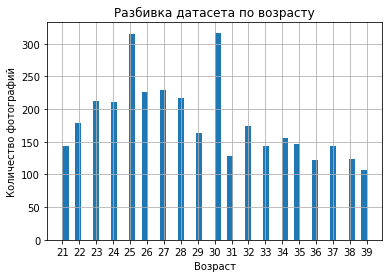

In [19]:
lab.hist(bins = 50)
plt.title('Разбивка датасета по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.xticks(range(min(lab['real_age']), max(lab['real_age'])+1))
plt.show()

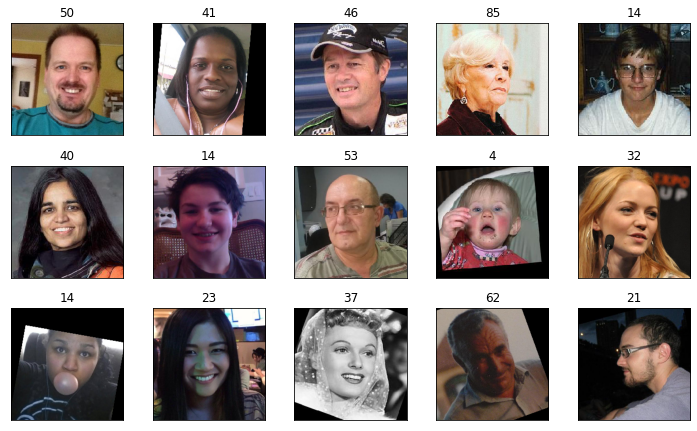

In [20]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выводы по данным:
1. Данные очень неоднородные, а значит точность у модели с людьми после 50 лет будет падать
2. В базе 7591 фотография для обучения
3. Иногда встречаются резкие всплески на некоторых возрастных группах, например, 25 лет, 30 лет
4. Сами фотографии очень разные, не всегда видно хорошо лицо, бывают лишние предметы, которые перекрывают часть изображения человека
5. Средний возраст человека на фотографии 31 год

## Обучение модели

optimizer = Adam(0.0001)

```python

#Загрузим обучающую выборку
def load_train(path):

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

```

```python

def load_test(path):

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

```

```python

#Создадим модель
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

```

```python

#Запустим модель
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 48s - loss: 270.9982 - mae: 11.7390 - val_loss: 893.5629 - val_mae: 25.0527
Epoch 2/10
178/178 - 39s - loss: 67.3821 - mae: 6.2015 - val_loss: 617.6785 - val_mae: 19.6425
Epoch 3/10
178/178 - 39s - loss: 31.5439 - mae: 4.3053 - val_loss: 201.8206 - val_mae: 10.9801
Epoch 4/10
178/178 - 41s - loss: 20.6626 - mae: 3.5231 - val_loss: 122.7955 - val_mae: 8.3722
Epoch 5/10
178/178 - 62s - loss: 15.1537 - mae: 2.9743 - val_loss: 78.4908 - val_mae: 6.7330
Epoch 6/10
178/178 - 63s - loss: 11.8022 - mae: 2.6574 - val_loss: 68.9222 - val_mae: 6.2781
Epoch 7/10
178/178 - 61s - loss: 9.3810 - mae: 2.3417 - val_loss: 66.5971 - val_mae: 6.2014
Epoch 8/10
178/178 - 62s - loss: 8.6930 - mae: 2.2129 - val_loss: 68.1088 - val_mae: 6.2395
Epoch 9/10
178/178 - 62s - loss: 7.3071 - mae: 2.0589 - val_loss: 68.2136 - val_mae: 6.2008
Epoch 10/10
178/178 - 43s - loss: 6.1167 - mae: 1.8689 - val_loss: 67.9455 - val_mae: 6.2063
60/60 - 10s - loss: 67.9455 - mae: 6.2063
Test MAE: 6.2063

```

## Анализ обученной модели

Выводы:
1. Датасет довольно-таки крупный, более 7 тысяч фотографий, но есть дисбаланс в фотографиях, значительно меньше человек возрастом более 50 лет в обучающей подборке. 
2. Средний возраст человека на фотографии 31 год
3. Модель обеспечила требуемое значение MAE, по тз требовалось ниже 8, фактическое на тесте 6.2
4. Разница в показатели между обучение и тестирование 0.1, значит модель не подверглась переобучению.
5. Для улучшения показателей рекомендация следующая: увеличить количество значений по людям старше 50 лет в обучающей выборке. 